# Train a fully convolutional network to detect dot center positions

In [1]:
import os
import errno

import numpy as np
    
import deepcell
from deepcell_spots.data_utils import get_data

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Load the training data

In [2]:
from deepcell_spots.data_utils import get_data

# Load the data from an npz file
npz_folder = r'/data/simulated_dots/'
filename = 'simulated_dots.npz'
DATA_DIR = '/data/simulated_dots/npz_data'
DATA_FILE = os.path.join(npz_folder,filename)

# train-test split - use the same seed and test_size as in train_model_conv to obtain same split
seed = 0
test_size=0.1 # % of data saved as test
train_dict, test_dict = get_data(DATA_FILE, test_size=test_size, seed=seed, allow_pickle=True)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (90, 128, 128, 1)
y.shape: (90,)


### Set up filepath constants

In [3]:
# Set up required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = r'/data'
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            
print('model dir: ', MODEL_DIR)
print('log dir: ', LOG_DIR)

model dir:  /data
log dir:  /data


### Set up training parameters

In [4]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

conv_model_name = 'conv_dots_model'

n_epoch = 10  # Number of training epochs
norm_method = None  # data normalization - options are: 'std','max', None, 'whole_image'
receptive_field = 13  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

### Create a dot detection model

#### Instantiate the model

In [5]:
from deepcell_spots.dotnet import dot_net_2D

dots_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=tuple(X_train.shape[1:]),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

input_shape: [128, 128, 128]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# dots_model.summary()

#### Train the model

In [7]:
from deepcell_spots.training import train_model_dot

train_model_dot(model=dots_model,
                dataset=DATA_FILE,
                test_size=test_size,
                seed=seed,
                n_epoch=n_epoch,
                batch_size=batch_size,
                optimizer=optimizer,
                log_dir=LOG_DIR,
                model_dir=MODEL_DIR,
                model_name=conv_model_name,
                focal=True,
                lr_sched=lr_sched,
                rotation_range=180,
                flip=True,
                shear=False,
                zoom_range=(0.8, 1.2),
                fill_mode='reflect'
                )

X_train shape: (90, 128, 128, 1)
y_train shape: (90,)
X_test shape: (10, 128, 128, 1)
y_test shape: (10,)
Output Shape: (None, 128, 128, 2)
Number of Classes: 2
Training on 0 GPUs
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
10/90 [==>...........................] - ETA: 51s - loss: 2.2816 - offset_regression_loss: 1.5015 - classification_loss: 0.7620 - offset_regression_acc: 0.6524 - classification_acc: 0.8198
Epoch 00001: val_loss improved from inf to 2.28160, saving model to /data/conv_dots_model.h5
90/90 [==============================] - 108s 1s/step - loss: 1.4932 - offset_regression_loss: 1.3786 - classification_loss: 0.0967 - offset_regression_acc: 0.5270 - classification_acc: 0.9515 - val_loss: 2.2816 - val_offset_regression_loss: 1.5015 - val_classification_loss: 0.7620 - val_offset_regression_acc: 0.6524 - val_classification_acc: 0.8198
Epoch 2/10
10/90 [==>...........................] - ETA: 46s - loss: 1.8059 - off

### Run the model

#### Make predictions on test data

In [86]:
y_pred_test = dots_model.predict(X_test)
print(len(X_test))
print('test image result shape:', y_pred_test[0].shape)

10
test image result shape: (10, 128, 128, 2)


## Plot raw predictions

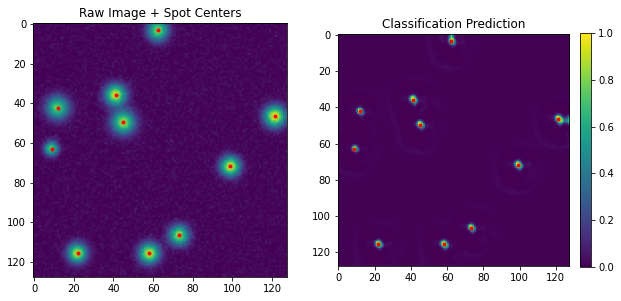

In [128]:
import matplotlib.pyplot as plt

## plot raw data, ground truth annotation vs classification results
ind = 0
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)

plt.imshow(X_test[ind,...,0])
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'.r')
plt.title('Raw Image + Spot Centers')

plt.subplot(1,2,2)
plt.imshow(y_pred_test[1][ind,...,1], vmin=0, vmax=1)
plt.title('Classification Prediction')
plt.colorbar(fraction=0.046, pad=0.04);plt.plot(y_test[ind][:,1],y_test[ind][:,0],'.r')

In [90]:
# generate offset images for the ground truth annotations
from deepcell_spots import image_generators

datagen = image_generators.ImageFullyConvDotDataGenerator()
points = y_test[ind]
it = datagen.flow(train_dict)
annotations = it.point_list_to_annotations(points, X_test.shape[1:3])
offset = annotations['offset']

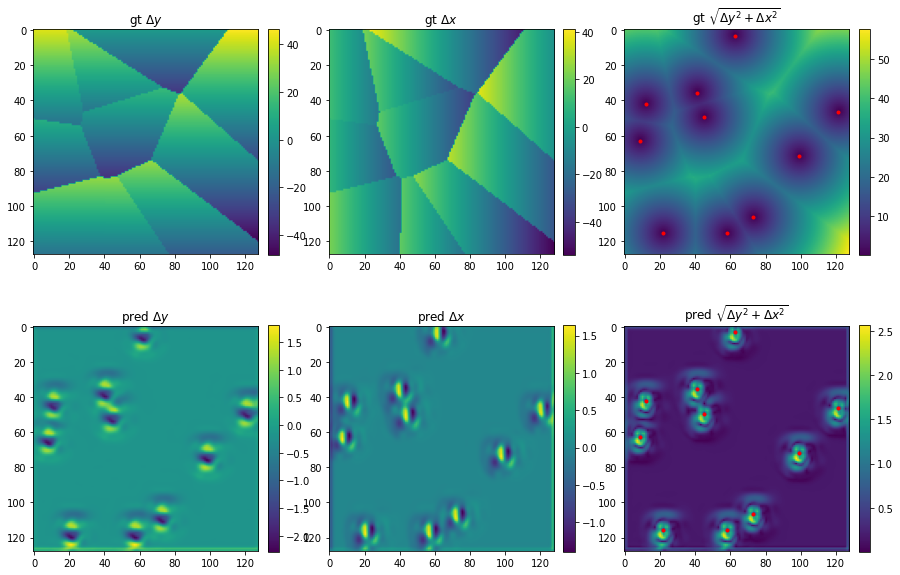

In [135]:
# plot regression ground truth vs prediction results
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(offset[...,0])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('gt $\Delta y$')
plt.subplot(2,3,2)
plt.imshow(offset[...,1])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('gt $\Delta x$')

plt.subplot(2,3,3)
d1 = np.sqrt(offset[...,0]**2 + offset[...,1]**2)
plt.imshow(d1)
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'.r')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('gt $\sqrt{\Delta y^2 + \Delta x^2}$');

plt.subplot(2,3,4)
plt.imshow(y_pred_test[0][ind,...,0])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('pred $\Delta y$')
plt.subplot(2,3,5)
plt.imshow(y_pred_test[0][ind,...,1])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('pred $\Delta x$')

plt.subplot(2,3,6)
d = np.sqrt(y_pred_test[0][ind,...,0]**2 + y_pred_test[0][ind,...,1]**2)
plt.imshow(d)
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'.r')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('pred $\sqrt{\Delta y^2 + \Delta x^2}$');

#### post-processing

In [92]:
def y_annotations_to_point_list(y_pred, ind, threshold):
    """ Convert raw prediction to a predicted point list
    
    Args:
    y_pred: a batch of predictions, of the format: y_pred[annot_type][ind] is an annotation for image #ind in the batch
    where annot_type = 0 or 1: 0 - contains_dot, 1 - offset matrices
    
    ind: the index of the image in the batch for which to convert the annotations
    
    threshold: a number in [0, 1]. Pixels with classification score > threshold are considered containing a spot center,
    and their corresponding regression values will be used to create a final spot position prediction which will
    be added to the output spot center coordinates list.
    
    Returns:
    A list of spot center coordinates of the format [[y0, x0], [y1, x1],...]
    """

    contains_dot = y_pred[1][ind,...,1] > threshold
    delta_y = y_pred[0][ind,...,0]
    delta_x = y_pred[0][ind,...,1]

    dot_pixel_inds = np.argwhere(contains_dot)
    dot_centers = np.array([[y_ind+delta_y[y_ind, x_ind],x_ind+delta_x[y_ind, x_ind]] for y_ind, x_ind in dot_pixel_inds])
    return dot_centers

In [93]:
ind = 0
threshold = 0.9

In [94]:
points_list = y_annotations_to_point_list(y_pred_test, ind, threshold)

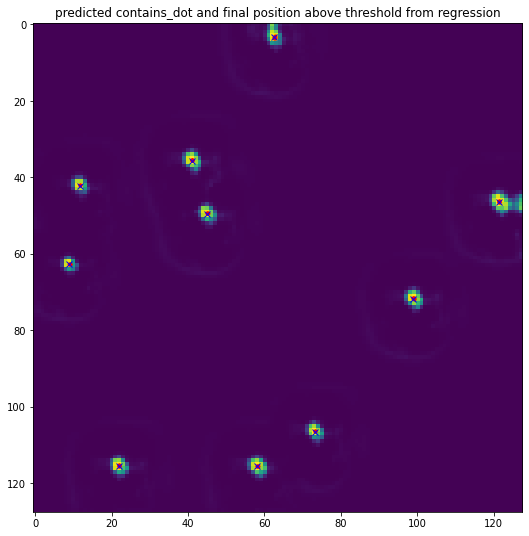

In [95]:
plt.figure(figsize=(9,9))
plt.imshow(y_pred_test[1][ind,...,1])
plt.plot(points_list[:,1], points_list[:,0],'.r')
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'xb') # plot ground truth positions
plt.title('predicted contains_dot and final position above threshold from regression');

# A more restrictive final prediction

In [65]:
def y_annotations_to_point_list2(y_pred, ind, threshold):
    # make final decision to be: classification of pixel as containing dot > threshold AND
    # center regression is contained in the pixel
    contains_dot = y_pred[1][ind,...,1] > threshold
    delta_y = y_pred[0][ind,...,0]
    delta_x = y_pred[0][ind,...,1]
    contains_its_regression = (abs(delta_x)<=0.5) & (abs(delta_y)<=0.5)
    
    final_dot_detection = contains_dot & contains_its_regression

    dot_pixel_inds = np.argwhere(final_dot_detection)
    dot_centers = np.array([[y_ind+delta_y[y_ind, x_ind],x_ind+delta_x[y_ind, x_ind]] for y_ind, x_ind in dot_pixel_inds])
    return dot_centers

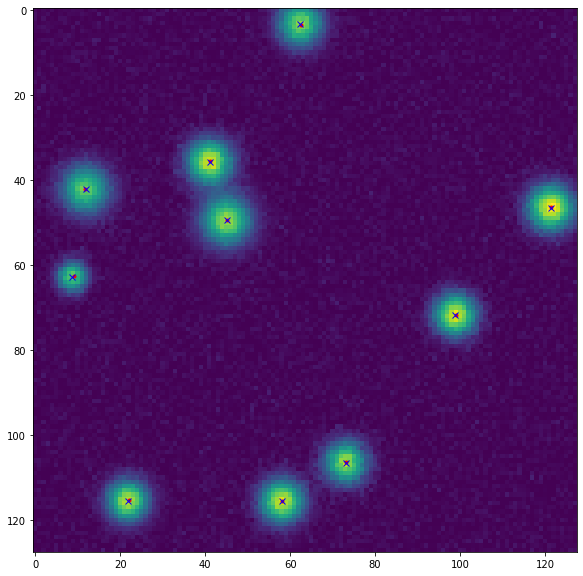

In [96]:
#ind = 0
# plots results with restrictive decision
plt.figure(figsize=(10,10))
plt.imshow(X_test[ind,...,0])

# mark above threshold pixels (opaque plot over original)
#threshold = 0.95
#above_thresh = y_pred_test[1][ind,...,1] > thresh
#plt.imshow(above_thresh, alpha=0.5)
points_list2 = y_annotations_to_point_list2(y_pred_test, ind, threshold)
# plot ground truth centers, and predictions
plt.plot(points_list2[:,1], points_list2[:,0],'.',color='r')
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'xb')

# Draw arrows from pixel center to regression prediction from that pixel

In [97]:
def y_annotations_to_point_list_with_source(y_pred, ind, threshold):
    """ Convert raw prediction to a predicted point list
    
    Args:
    y_pred: a batch of predictions, of the format: y_pred[annot_type][ind] is an annotation for image #ind in the batch
    where annot_type = 0 or 1: 0 - contains_dot, 1 - offset matrices
    
    ind: the index of the image in the batch for which to convert the annotations
    
    threshold: a number in [0, 1]. Pixels with classification score > threshold are considered containing a spot center,
    and their corresponding regression values will be used to create a final spot position prediction which will
    be added to the output spot center coordinates list.
    
    Returns:
    A list of spot center coordinates of the format [[y0, x0], [y1, x1],...]
    """

    contains_dot = y_pred[1][ind,...,1] > threshold
    delta_y = y_pred[0][ind,...,0]
    delta_x = y_pred[0][ind,...,1]

    dot_pixel_inds = np.argwhere(contains_dot)
    dot_centers = np.array([[y_ind+delta_y[y_ind, x_ind],x_ind+delta_x[y_ind, x_ind]] for y_ind, x_ind in dot_pixel_inds])
    return dot_centers, dot_pixel_inds

In [80]:
dot_centers, dot_pixel_inds = y_annotations_to_point_list_with_source(y_pred_test, ind, threshold)
print('number of positive detections: ', dot_centers.shape[0])

number of positive detections:  21


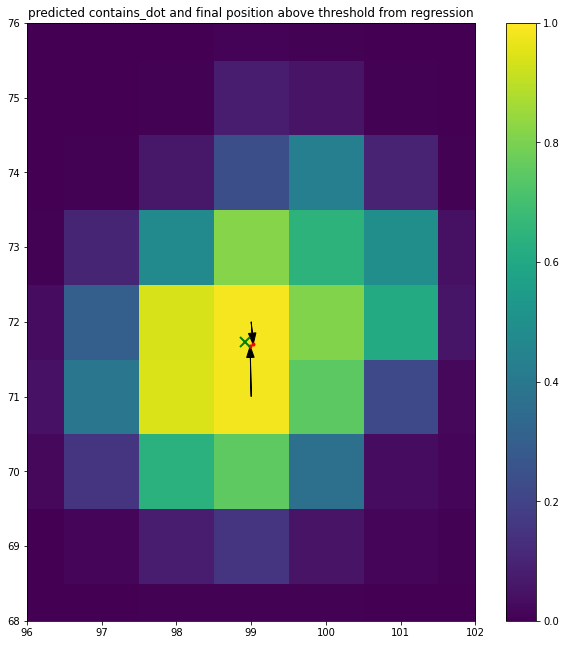

In [131]:
plt.figure(figsize=(11,11))
plt.imshow(y_pred_test[1][ind,...,1], vmin=0, vmax=1)
plt.plot(dot_centers[:,1], dot_centers[:,0],'.r')
plt.plot(y_test[ind][:,1],y_test[ind][:,0],'xg',mew=2,markersize=10) # plot ground truth positions
plt.title('predicted contains_dot and final position above threshold from regression');
plt.colorbar()

# plot arrows
for (y, x), (y_pixel, x_pixel) in zip(dot_centers, dot_pixel_inds):
    plt.arrow(x_pixel, y_pixel, x - x_pixel, y - y_pixel, head_width=0.1, length_includes_head=True,color='k')
    
# zoom in on interesting area (selected for example image)
plt.xlim(96,102);
plt.ylim(68,76);